In [1]:
from tensorflow import keras

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import warnings
from skimage.color import rgb2hed,hed2rgb
%matplotlib inline
USE_CUDA = torch.cuda.is_available() 
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
def cuda(v):
    if USE_CUDA:
        return v.cuda()
    return v
def toTensor(v,dtype = torch.float,requires_grad = False):       
    return cuda(Variable(torch.tensor(v)).type(dtype).requires_grad_(requires_grad))
def toNumpy(v):
    if USE_CUDA:
        return v.detach().cpu().numpy()
    return v.detach().numpy()

In [3]:
X = np.load("CoNIC_Challenge/images.npy")
Y = pd.read_csv("coNIC_Challenge/counts.csv")
F = np.loadtxt("https://raw.githubusercontent.com/foxtrotmike/CS909/master/2022/A2/split.txt")

## Question1 Data Analysis

##### i. How many examples are there in each fold?

In [15]:
print('Fold 1 : ',len(F[F==1]))
print('Fold 2 : ',len(F[F==2]))
print('Fold 3 : ',len(F[F==3]))

Fold 1 :  1622
Fold 2 :  1751
Fold 3 :  1608


##### ii. Show some image examples using plt.imshow.

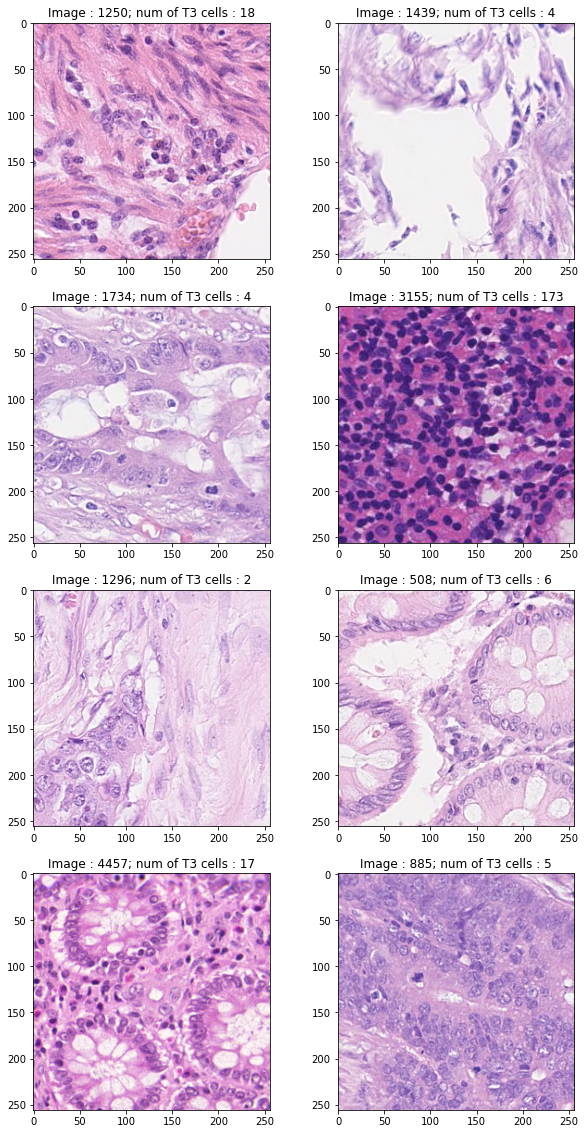

In [83]:
plt.figure(num='ich',figsize=(10,20))
count = 1
for i in random.sample(range(1,X.shape[0]),8):
    plt.subplot(4,2,count)
    count = count +1
    plt.title(f"Image : {i}; num of T3 cells : {Y['lymphocyte'][i]}")
    plt.imshow(X[i,])

##### Describe your observations

the figure with deeper colors seems to have more numbers of cells in T3 type because the cell nuclear of is dyed with deep purple.

##### iii. plot the histogram of counts of each cell type separately 

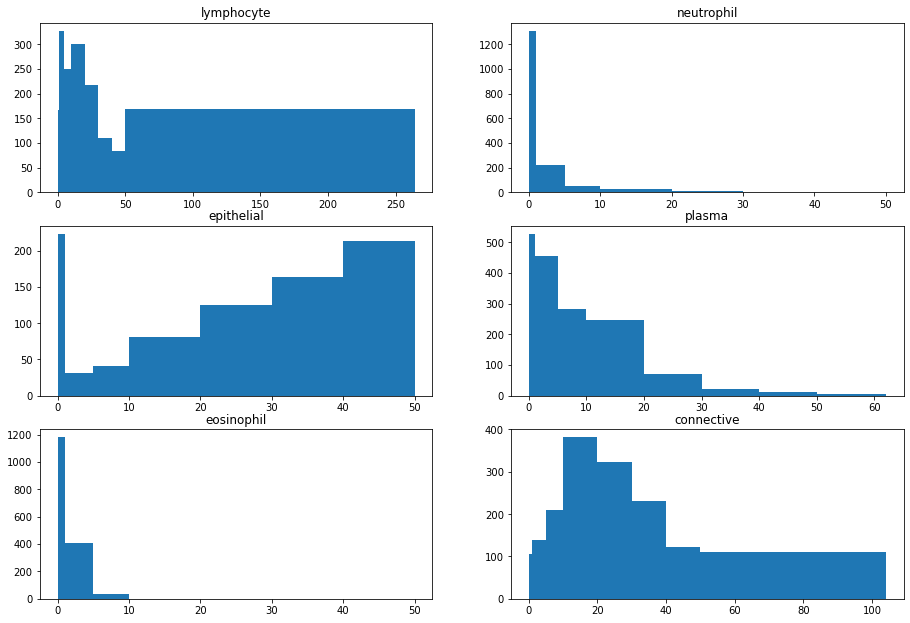

In [6]:
plt.subplots_adjust(left=1,bottom=1,top=3,right=3,)
plt.subplot(3,2,1)
plt.hist(ytrain.lymphocyte,bins=[0,1,5,10,20,30,40,50,max(ytrain.lymphocyte)])
plt.title("lymphocyte")
plt.subplot(3,2,2)
plt.hist(ytrain.neutrophil,bins=[0,1,5,10,20,30,40,50,max(ytrain.neutrophil)])
plt.title("neutrophil")
plt.subplot(3,2,3)
plt.hist(ytrain.epithelial,bins=[0,1,5,10,20,30,40,50])
plt.title("epithelial")
plt.subplot(3,2,4)
plt.hist(ytrain.plasma,bins=[0,1,5,10,20,30,40,50,max(ytrain.plasma)])
plt.title("plasma")
plt.subplot(3,2,5)
plt.hist(ytrain.eosinophil,bins=[0,1,5,10,20,30,40,50])
plt.title("eosinophil")
plt.subplot(3,2,6)
plt.hist(ytrain.connective,bins=[0,1,5,10,20,30,40,50,max(ytrain.connective)])
plt.title("connective")
plt.show()

##### iv. Convert and show a few images from RGB space to HED space and show the H-channel which should indicate cellular nuclei

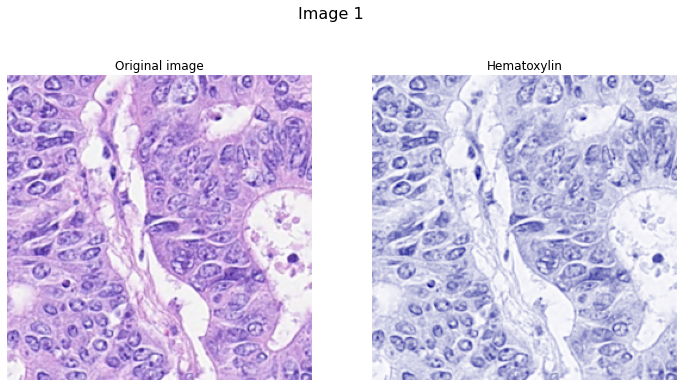

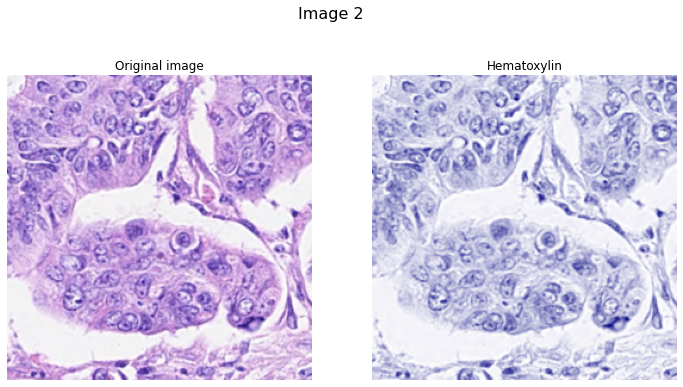

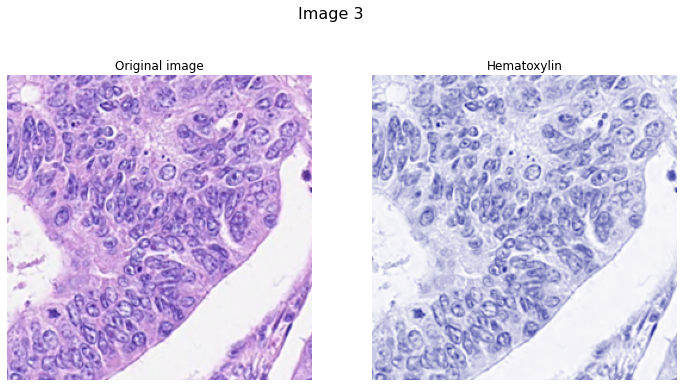

In [92]:
import matplotlib.pyplot as plt
from skimage.color import rgb2hed
from matplotlib.colors import LinearSegmentedColormap

# Create an artificial color close to the original one
cmap_hema = LinearSegmentedColormap.from_list('mycmap', ['white', 'navy'])

for i in range(1,4):
    ihc_rgb = X[i-1]
    ihc_hed = rgb2hed(ihc_rgb)
    
    fig = plt.figure()
    fig.set_size_inches(w=12,h=6)

    plt.suptitle(f'Image {i}',ha = 'center',va = 'bottom', fontsize=16)
    ax1 = plt.subplot2grid((1,2), (0,0))
    ax2 = plt.subplot2grid((1,2), (0,1))

    ax1.imshow(ihc_rgb)
    ax1.set_title("Original image")
    ax1.axis('off')

    ax2.imshow(ihc_hed[:, :, 0], cmap=cmap_hema)
    ax2.set_title("Hematoxylin")
    ax2.axis('off')

    plt.show()

##### v. Do a scatter plot of the average of the H-channel for each image vs. its cell count of a certain type for images in Fold-1 (6 plots in total).

In [19]:
x_hed = rgb2hed(X)
# avg H channel vs. count of certain type
x_h = x_hed[:,:, :, 0]
h_avg = np.mean(np.mean(x_h,axis=1),axis=1)

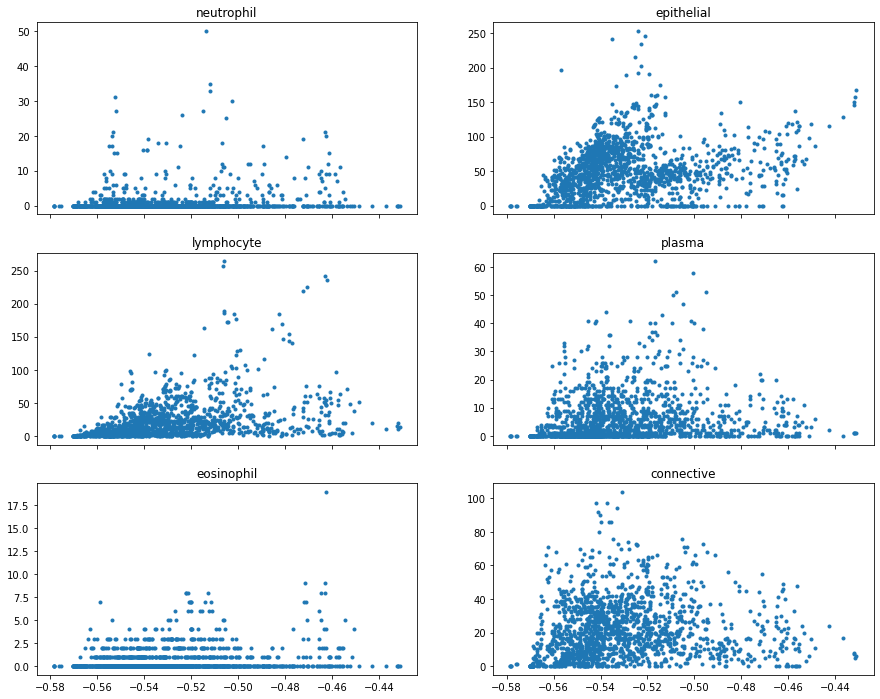

In [95]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True, sharey=False)
ax = axes.ravel()
i=0
for col_name,col in Y[F==1].items():
    ax[i].plot(h_avg[F==1],col,'.')
    ax[i].set_title(col_name)
    i+=1


######  Do you think this feature would be useful in your regression model?

From the scatter plot we can see that there is somewhat a linear association between the cell count and the mean of H-channel. It is believed that this feature is useful for the regression model.

##### vi. What performance metrics can you use for this problem? Which one will be the best performance metric for this problem? 

RMSE, R-square, and correlation coefficient can be used.

    R2 is more suitable for measuring how well variables can be predicted by the regression model. 
    RMSE should be considered when we compare the validation data.
    Correlation coefficient is useful when selecting featrues for regression.

# Question2 Feature extraction & Traditional Regression 

## i.Extract features from a given image.

extraxt mean, variance, Entropy of channel R G B H.

In [20]:
H = x_hed[:,:,:,0]
R = X[:,:,:,0]
G = X[:,:,:,1]
B = X[:,:,:,2]
H_ = H.reshape(4981,-1)
R_ = R.reshape(4981,-1)
G_ = G.reshape(4981,-1)
B_ = B.reshape(4981,-1)
avg_h = np.mean(H_,axis=1)
avg_r = np.mean(R_,axis=1)
avg_g = np.mean(G_,axis=1)
avg_b = np.mean(B_,axis=1)
var_h = np.var(H_,axis=1)
var_r = np.var(R_,axis=1)
var_g = np.var(G_,axis=1)
var_b = np.var(B_,axis=1)
from skimage.measure import shannon_entropy
ent_r,ent_g,ent_b,ent_h = [],[],[],[]
for i in range(0,R_.shape[0]):
    ent_r.append(shannon_entropy(R[i,:],base=2))
    ent_g.append(shannon_entropy(G[i,:],base=2))
    ent_b.append(shannon_entropy(B[i,:],base=2))
    ent_h.append(shannon_entropy(H[i,:],base=2))

#### Mean

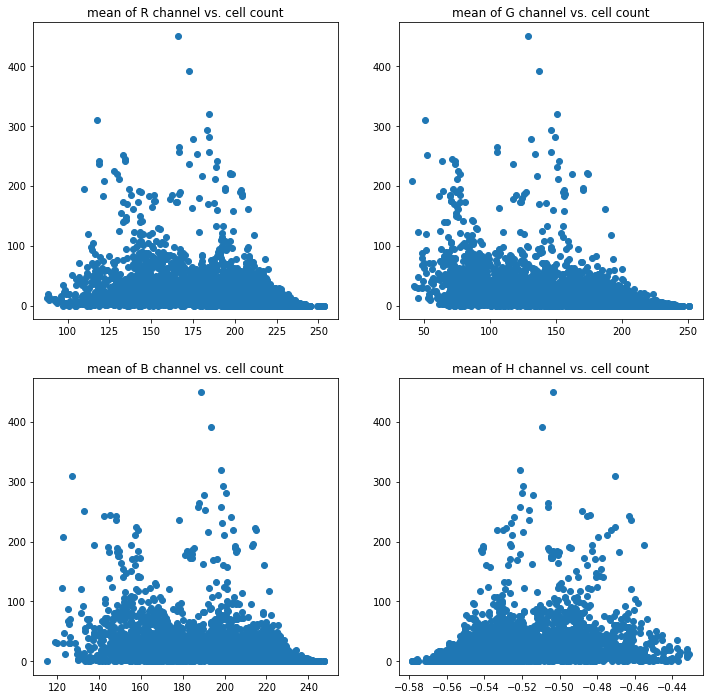

In [11]:
fig, axes = plt.subplots(2,2, figsize=(12, 12), sharex=False, sharey=False);
ax = axes.ravel()
ax[0].scatter(avg_r,Y.lymphocyte)
ax[0].set_title('mean of R channel vs. cell count')
ax[1].scatter(avg_g,Y.lymphocyte)
ax[1].set_title('mean of G channel vs. cell count')
ax[2].scatter(avg_b,Y.lymphocyte)
ax[2].set_title('mean of B channel vs. cell count')
ax[3].scatter(avg_h,Y.lymphocyte)
ax[3].set_title('mean of H channel vs. cell count');

#### variance

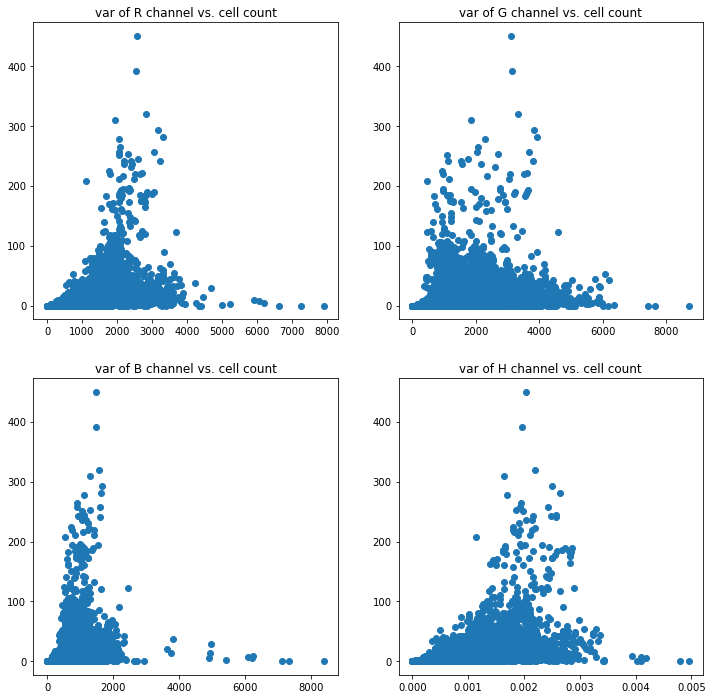

In [12]:
fig, axes = plt.subplots(2,2, figsize=(12, 12), sharex=False, sharey=False)
ax = axes.ravel()
ax[0].scatter(var_r,Y.lymphocyte)
ax[0].set_title('var of R channel vs. cell count')
ax[1].scatter(var_g,Y.lymphocyte)
ax[1].set_title('var of G channel vs. cell count')
ax[2].scatter(var_b,Y.lymphocyte)
ax[2].set_title('var of B channel vs. cell count')
ax[3].scatter(var_h,Y.lymphocyte)
ax[3].set_title('var of H channel vs. cell count');


#### entropy

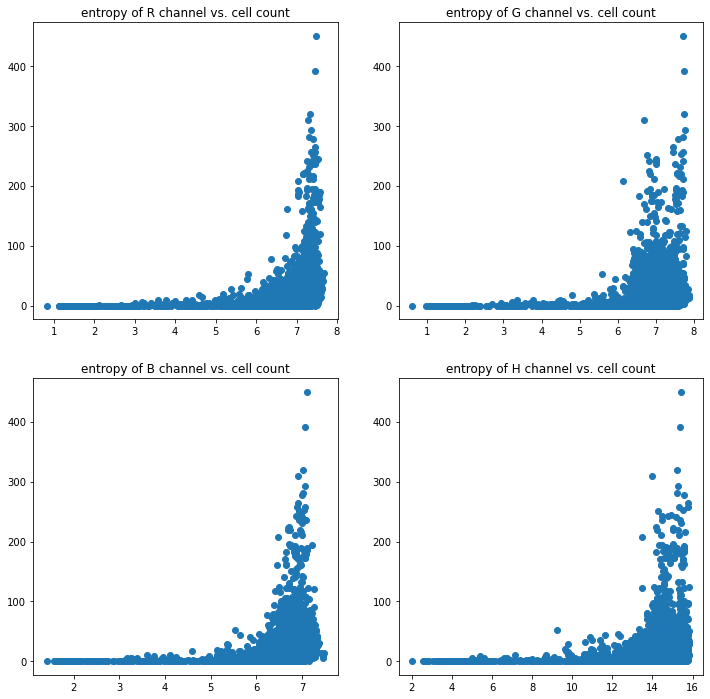

In [13]:
fig, axes = plt.subplots(2,2, figsize=(12, 12), sharex=False, sharey=False)
ax = axes.ravel()
ax[0].scatter(ent_r,Y.lymphocyte)
ax[0].set_title('entropy of R channel vs. cell count')
ax[1].scatter(ent_g,Y.lymphocyte)
ax[1].set_title('entropy of G channel vs. cell count')
ax[2].scatter(ent_b,Y.lymphocyte)
ax[2].set_title('entropy of B channel vs. cell count')
ax[3].scatter(ent_h,Y.lymphocyte)
ax[3].set_title('entropy of H channel vs. cell count');

### PCA

In [33]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
randpca = PCA(n_components=1,svd_solver='randomized')
Rs=preprocessing.scale(R_)
randpca.fit(Rs)
comp = randpca.transform(Rs)
pca_r=comp.reshape(-1,1)

Gs=preprocessing.scale(G_)
randpca.fit(Gs)
comp = randpca.transform(Gs)
pca_g=comp.reshape(-1,1)

Bs=preprocessing.scale(B_)
randpca.fit(Bs)
comp = randpca.transform(Bs)
pca_b=comp.reshape(-1,1)

Hs=preprocessing.scale(H_)
randpca.fit(Hs)
comp = randpca.transform(Hs)
pca_h=comp.reshape(-1,1)

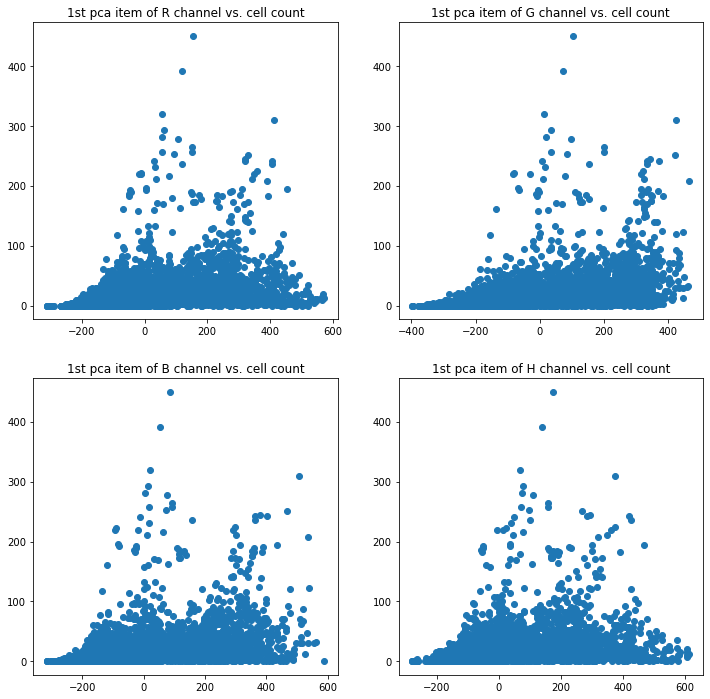

In [15]:
fig, axes = plt.subplots(2,2, figsize=(12, 12), sharex=False, sharey=False)
ax = axes.ravel()
ax[0].scatter(pca_r[:,0],Y.lymphocyte)
ax[0].set_title('1st pca item of R channel vs. cell count')
ax[1].scatter(pca_g[:,0],Y.lymphocyte)
ax[1].set_title('1st pca item of G channel vs. cell count')
ax[2].scatter(pca_b[:,0],Y.lymphocyte)
ax[2].set_title('1st pca item of B channel vs. cell count')
ax[3].scatter(pca_h[:,0],Y.lymphocyte)
ax[3].set_title('1st pca item of H channel vs. cell count');

### GLCM

in this part we extract 6 features calculated by greycomatrix for each channel, these features are useful showing textures of images

In [23]:
X_int =(255*X_).astype(np.uint8)
R_glcm= np.zeros([len(X_int),6,4]) 
G_glcm= np.zeros([len(X_int),6,4]) 
B_glcm= np.zeros([len(X_int),6,4]) 
from skimage.feature import greycomatrix, greycoprops;
from math import pi
for i in range(0,len(X_int)):
    for j in range(0,3):
        glcm = greycomatrix(X_int[i,:,:,j], distances=[5], angles=[0,0.25*pi,0.5*pi,0.75*pi], levels=256,symmetric=True, normed=True)
        if j==0:
            R_glcm[i,0] = greycoprops(glcm,'contrast')
            R_glcm[i,1] = greycoprops(glcm,'dissimilarity')
            R_glcm[i,2] = greycoprops(glcm,'homogeneity')
            R_glcm[i,3] = greycoprops(glcm,'ASM')
            R_glcm[i,4] = greycoprops(glcm,'energy')
            R_glcm[i,5] = greycoprops(glcm,'correlation')
        elif j==1:
            G_glcm[i,0] = greycoprops(glcm,'contrast')
            G_glcm[i,1] = greycoprops(glcm,'dissimilarity')
            G_glcm[i,2] = greycoprops(glcm,'homogeneity')
            G_glcm[i,3] = greycoprops(glcm,'ASM')
            G_glcm[i,4] = greycoprops(glcm,'energy')
            G_glcm[i,5] = greycoprops(glcm,'correlation')
        else:
            B_glcm[i,0] = greycoprops(glcm,'contrast')
            B_glcm[i,1] = greycoprops(glcm,'dissimilarity')
            B_glcm[i,2] = greycoprops(glcm,'homogeneity')
            B_glcm[i,3] = greycoprops(glcm,'ASM')
            B_glcm[i,4] = greycoprops(glcm,'energy')
            B_glcm[i,5] = greycoprops(glcm,'correlation')
R_glcm = R_glcm.reshape(len(X_int),-1)
G_glcm = G_glcm.reshape(len(X_int),-1)
B_glcm = B_glcm.reshape(len(X_int),-1)

##### calculate the correlation coefficient of each feature

In [205]:
from scipy.stats import pearsonr
Y3 = Y.lymphocyte.values
print('correlation coefficient of mean & T3 number')
for x in [avg_r,avg_g,avg_b,avg_h]:
    co=pearsonr(Y3,x)
    print(co)
print('correlation coefficient of variance & T3 number')
for x in [var_r,var_g,var_b,var_h]:
    co=pearsonr(Y3,x)
    print(co)
print('correlation coefficient of entropy & T3 number')
for x in [ent_r,ent_g,ent_b,ent_h]:
    co=pearsonr(Y3,x)
    print(co)
print('correlation coefficient of PCA 1 & T3 number')
for x in [pca_r[:,0],pca_g[:,0],pca_b[:,0],pca_h[:,0]]:
    co=pearsonr(Y3,x)
    print(co)



correlation coefficient of mean & T3 number
(array([-0.36046827562410627], dtype=object), 1.016008876916462e-152)
(array([-0.3856703183773153], dtype=object), 2.262151730572119e-176)
(array([-0.37574599037357703], dtype=object), 8.336216352783637e-167)
(array([0.339613375495666], dtype=object), 1.0589827831629847e-134)
correlation coefficient of variance & T3 number
(array([0.40163870998506773], dtype=object), 1.779084061257092e-192)
(array([0.1288476137622293], dtype=object), 6.889959675340058e-20)
(array([0.24206174107786166], dtype=object), 2.431691012310927e-67)
(array([0.46312361589846296], dtype=object), 2.379595839994737e-263)
correlation coefficient of entropy & T3 number
(array([0.32036612575055196], dtype=object), 2.9123242038236995e-119)
(array([0.21574618278377639], dtype=object), 1.5271454072684612e-53)
(array([0.2879208164617832], dtype=object), 1.0748886797491078e-95)
(array([0.2072629710683757], dtype=object), 1.8310101287842037e-49)
correlation coefficient of PCA 1 & T

## ii. Try the following regression models with the features used in part-1

### a. Ordinary Least Squares (OLS) regression

In [206]:
ent_r = np.asarray(ent_r)
ent_g = np.asarray(ent_g)
ent_b = np.asarray(ent_b)
ent_h = np.asarray(ent_h)
avg_r = avg_r.reshape(4981,-1);
avg_g = avg_g.reshape(4981,-1);
avg_b = avg_b.reshape(4981,-1);
avg_h = avg_h.reshape(4981,-1);
var_r = var_r.reshape(4981,-1)
var_g = var_g.reshape(4981,-1)
var_b = var_b.reshape(4981,-1)
var_h = var_h.reshape(4981,-1)
ent_r = ent_r.reshape(4981,-1)
ent_g = ent_g.reshape(4981,-1)
ent_b = ent_b.reshape(4981,-1)
ent_h = ent_h.reshape(4981,-1)
pca_r = pca_r.reshape(4981,-1)
pca_g = pca_g.reshape(4981,-1)
pca_b = pca_b.reshape(4981,-1)
pca_h = pca_h.reshape(4981,-1)

In [213]:
X1 = np.hstack((avg_r,avg_b,avg_g,avg_h,var_r,var_g,var_b,var_h,ent_r,ent_g,ent_b,ent_h))
X2 = np.hstack((R_glcm,G_glcm,B_glcm))
X_= np.hstack((X1,X2))

RMSE: 19.56074477587258
CORR: 0.782226473598991
R2: 0.5617721247429315


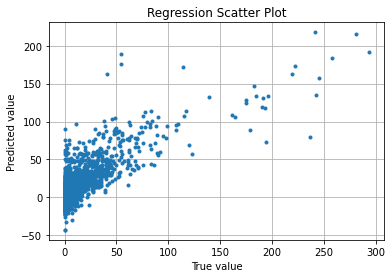

In [212]:
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from math import sqrt
warnings.filterwarnings('ignore')
Xtrain, Xtest = X2[F!=3],X2[F==3] 
Ytrain, Ytest = Y.lymphocyte[F!=3], Y.lymphocyte[F==3]
clf = linear_model.LinearRegression(copy_X=True,fit_intercept=True, n_jobs=-1, normalize=True)
clf.fit(Xtrain,Ytrain)
ypred = clf.predict(Xtest)
rmse = sqrt(mean_squared_error(Ytest, ypred))
corr,_ = pearsonr(Ytest,ypred)
r2 = r2_score(Ytest,ypred)
print('RMSE:',rmse)
print('CORR:',corr)
print('R2:',r2)
plt.figure();plt.plot(Ytest,ypred,'.');plt.grid();plt.xlabel('True value');plt.ylabel('Predicted value');plt.title('Regression Scatter Plot');

### b. Support Vector Regression

In [221]:
Xtrain, Xtest = X_[F!=3],X_[F==3]
Ytrain, Ytest = Y.lymphocyte[F!=3], Y.lymphocyte[F==3]

from sklearn import svm
from sklearn.model_selection import GridSearchCV
svc = svm.SVC(max_iter=-1)
param_grid = [
  {'C': [0.001,0.01,1, 10, 100], 'gamma': [0.01,0.001, 0.0001],'degree':[2,3,4], 'kernel': ['poly']},
  {'C': [0.001,0.01,1, 10, 100], 'gamma': [0.01,0.001, 0.0001],'kernel': ['rbf']},
  {'C': [0.01,0.1,1,10,100], 'gamma': [0.001,0.0005,0.0001],'coef0':[0,0.1,1,10], 'kernel': ['sigmoid']}
]
clf = GridSearchCV(svc,param_grid,n_jobs=-1,scoring='average_precision')
clf.fit(Xtrain, Ytrain);
clf = clf.best_estimator_;
ypred = clf.predict(Xtest)

SVC(C=100, gamma=0.0001, kernel='rbf')


##### RMSE, Pearson Correlation Coefficient, Spearman Correlation Coefficient and R2 score

RMSE: 22.723786862468337
CORR: 0.661936039043826
R2: 0.40858730806847376


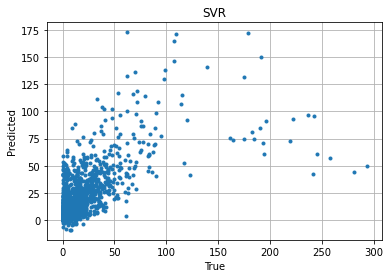

In [215]:
rmse = sqrt(mean_squared_error(Ytest, ypred))
corr,_ = pearsonr(Ytest,ypred)
r2 = r2_score(Ytest,ypred)
print('RMSE:',rmse)
print('CORR:',corr)
print('R2:',r2)
plt.figure();
plt.plot(Ytest,ypred,'.');
plt.grid();
plt.xlabel('True');
plt.ylabel('Predicted');
plt.title('SVR');

## Question3 CNN

## (Best Performance)
using CNN
\
performace metrix:

|   RMSE     |    R square   |   spearman   |pearson|
|:----:|:----:|:----:|:----:|
| 12.095971212372486 |   0.8652063697489187| 0.8738689034842683|0.9472730922267654|

### a.

In [20]:
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD
from keras import optimizers
from keras.layers import Dense, Dropout,Conv2D,MaxPool2D,Flatten,GlobalAveragePooling2D,BatchNormalization,AveragePooling2D
from keras import backend as K
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
def r_square(y_true, y_pred):
    SSR = K.mean(K.square(y_pred-K.mean(y_true)))
    SST = K.mean(K.square(y_true-K.mean(y_true)))
    return SSR/SST
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)

##### Build the main architecture of my model 
here because of the seriouse over-fitting problem occured, I adopt some methods to enhance generalization ability of the model. 
/
In concret, I add Dropout layer with bigger parameter, use GlobalAveragePooling instead of Flatten, and add L2 penalty to the Convolutional layers.

###### report your results in terms of RMSE, Pearson Correlation Coefficient, Spearman Correlation Coefficient and R2 score.

In [153]:
ypred = model.predict(Xtrain[F==3])

rmse = sqrt(mean_squared_error(Ytest, ypred))
from scipy import stats
scorr,_ = stats.spearmanr(Ytrain[F==3],ypred)
r2 = r2_score(Ytrain[F==3],ypred)
pcorr,_ = pearsonr(Ytrain[F==3],ypred)

print('spearman correlation:',scorr)
print('RMSE',rmse)
print('R2',r2)
print('pearson correlation ',pcorr)

spearman correlation: 0.8096180233958761
RMSE 13.222167044321472
R2 0.7997675297459944
pearson correlation  [0.8944078345524401]


###### Report results on the test examples by plotting the scatter plot

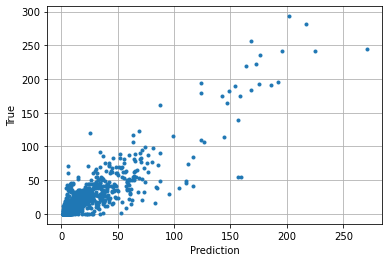

In [152]:
plt.plot(ypred,Ytrain[F==3],'.')
plt.grid()
plt.xlabel('Prediction')
plt.ylabel('True')

##### convergence plots

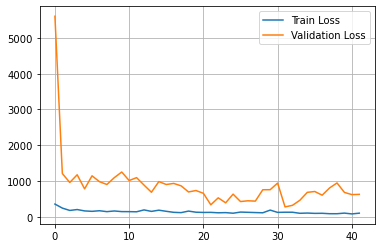

In [164]:
plt.plot(model_history.history['loss'][3:],'-',label = 'Train Loss')
plt.plot(model_history.history['val_loss'][3:],'-',label = 'Validation Loss')
plt.legend()
plt.grid()

In [156]:
model.save("first_model")

2022-03-22 21:13:13.259141: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: first_model/assets


### B.

#### Use three fold cross validation with your optimal network architecture to predict the counts of T3 cells.

In [251]:
np.random.seed(seed)
Ypred = np.zeros(4981).reshape(4981,-1)
Xtrain = X
modelb = model
# 3 Fold
callback = keras.callbacks.EarlyStopping(monitor="val_loss",patience=6,restore_best_weights=True,mode='min')
for i in [1,2,3]:
    Xtrain,Xv, Ytrain,Yv = train_test_split(X[F!=i], Y.lymphocyte.values[F!=i],test_size = 0.3)
    Xtest = X[F==i];
    Ytest = Y.lymphocyte.values[F==i]
    modelb_history = modelb.fit(Xtrain,Ytrain, 
                          epochs=15, 
                          batch_size=100, 
                          callbacks=[callback],
                          validation_data=(Xv, Yv))
    ypred = modelb.predict(Xtest)
    Ypred[F==i] = ypred
    rmse = sqrt(mean_squared_error(Ytest, ypred));
    scorr,_ = stats.spearmanr(Ytest,ypred);
    r2 = r2_score(Ytest,ypred);
    pcorr,_ = pearsonr(Ytest,ypred);
    print('RMSE',rmse)
    print('R2',r2)
    print('spearman correlation:',scorr)
    print('pearson correlation ',pcorr)



Epoch 1/15
24/24 [==============================] - 68s 3s/step - loss: 100.0638 - r_square: 0.9932 - pearson_r: 0.9652 - val_loss: 207.0222 - val_r_square: 1.0018 - val_pearson_r: 0.8848
Epoch 2/15
24/24 [==============================] - 68s 3s/step - loss: 138.2744 - r_square: 1.0802 - pearson_r: 0.9525 - val_loss: 181.6051 - val_r_square: 0.8941 - val_pearson_r: 0.8976
Epoch 3/15
24/24 [==============================] - 68s 3s/step - loss: 115.4046 - r_square: 0.9813 - pearson_r: 0.9640 - val_loss: 142.0485 - val_r_square: 0.9181 - val_pearson_r: 0.9336
Epoch 4/15
24/24 [==============================] - 68s 3s/step - loss: 124.5283 - r_square: 1.1496 - pearson_r: 0.9648 - val_loss: 203.3216 - val_r_square: 1.0996 - val_pearson_r: 0.8771
Epoch 5/15
24/24 [==============================] - 69s 3s/step - loss: 100.1169 - r_square: 1.0054 - pearson_r: 0.9609 - val_loss: 386.2455 - val_r_square: 0.4330 - val_pearson_r: 0.8688
Epoch 6/15
24/24 [==============================] - 69s 3s/s

|Test Fold    |   RMSE     |    R square   |   spearman   |pearson|
|:----:|:----:|:----:|:----:|:----:|
|0   | 11.55 |   0.8386  | 0.8908|0.9190|
|1   |  12.09 | 0.8652   | 0.8738|0.9472|
|2   | 11.18    | 0.8568    |  0.8177 |0.9256|

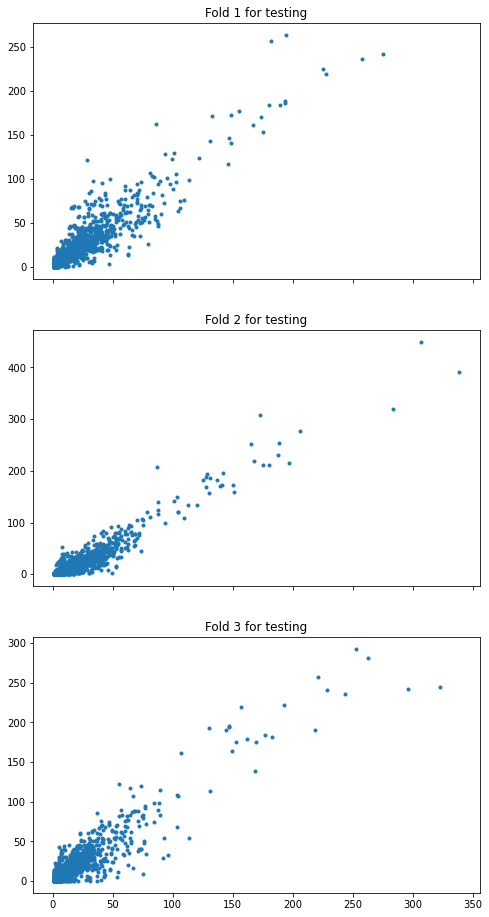

In [267]:
fig, axes = plt.subplots(3, 1, figsize=(8,16 ), sharex=True, sharey=False)
ax = axes.ravel()
ax[0].plot(Ypred[F==1],Y.lymphocyte.values[F==1],'.')
ax[0].set_title('Fold 1 for testing')
ax[1].plot(Ypred[F==2],Y.lymphocyte.values[F==2],'.')
ax[1].set_title('Fold 2 for testing')
ax[2].plot(Ypred[F==3],Y.lymphocyte.values[F==3],'.')
ax[2].set_title('Fold 3 for testing');

### C.  predict the counts of 6 types of cells simultaneously 

In [8]:
modelcv = Sequential()

modelcv.add(Conv2D(filters=16,kernel_size=5,padding='same',activation='relu',input_shape=(256,256,3)))
modelcv.add(BatchNormalization())
modelcv.add(MaxPool2D())

modelcv.add(Conv2D(filters=16,kernel_size=3,padding='same',activation='relu'))
modelcv.add(AveragePooling2D())

modelcv.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',kernel_regularizer = keras.regularizers.l2(0.01)))
modelcv.add(BatchNormalization())
modelcv.add(MaxPool2D())

modelcv.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu',kernel_regularizer = keras.regularizers.l2(0.1)))
modelcv.add(BatchNormalization())
modelcv.add(MaxPool2D())

modelcv.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu',kernel_regularizer=keras.regularizers.l2(0.1)))
modelcv.add(BatchNormalization())
modelcv.add(MaxPool2D())

modelcv.add(GlobalAveragePooling2D())
modelcv.add(Dense(1024, input_dim=7*7*128, activation='relu'))
modelcv.add(Dropout(.5))
modelcv.add(Dense(64, activation='relu'))
modelcv.add(Dense(6, activation='relu'))

# Compile
modelcv.compile(loss='mse', optimizer=Adam(learning_rate=0.005), metrics=[r_square,pearson_r])

#### Fold 1 for test

In [10]:
Xtrain,Xv, Ytrain,Yv = train_test_split(X[F!=1], Y.values[F!=1],test_size = 0.3)
# Fit
callback = keras.callbacks.EarlyStopping(monitor="val_loss",patience=10,restore_best_weights=True,mode='min')
model_history = modelcv.fit(Xtrain,Ytrain, 
                          epochs=25, 
                          batch_size=100, 
                          callbacks=[callback],
                          validation_data=(Xv, Yv))

Epoch 1/25
24/24 [==============================] - 72s 3s/step - loss: 323.0594 - r_square: 0.5761 - pearson_r: 0.5439 - val_loss: 11573.7207 - val_r_square: 22.8024 - val_pearson_r: -0.0542
Epoch 2/25
24/24 [==============================] - 70s 3s/step - loss: 242.9075 - r_square: 0.7147 - pearson_r: 0.6981 - val_loss: 6525.1650 - val_r_square: 13.5658 - val_pearson_r: 0.0020
Epoch 3/25
24/24 [==============================] - 70s 3s/step - loss: 220.4121 - r_square: 0.7513 - pearson_r: 0.7436 - val_loss: 568.1592 - val_r_square: 1.2756 - val_pearson_r: 0.3449
Epoch 4/25
24/24 [==============================] - 69s 3s/step - loss: 200.0933 - r_square: 0.7712 - pearson_r: 0.7613 - val_loss: 420.9498 - val_r_square: 0.8076 - val_pearson_r: 0.3907
Epoch 5/25
24/24 [==============================] - 69s 3s/step - loss: 185.4310 - r_square: 0.8235 - pearson_r: 0.7887 - val_loss: 495.3874 - val_r_square: 0.8311 - val_pearson_r: 0.1847
Epoch 6/25
24/24 [==============================] - 69

----------------------------------
T 1  cell TestFold 1: 
RMSE 2.66679251989677
R2 -0.08535060066638978
spearman correlation: -0.01301889944115377
pearson correlation  -0.006018570594207794
----------------------------------
T 2  cell TestFold 1: 
RMSE 19.775360220864364
R2 0.658257756383565
spearman correlation: 0.8483188115212696
pearson correlation  0.832329538231939
----------------------------------
T 3  cell TestFold 1: 
RMSE 26.240947061466827
R2 0.3010898173575317
spearman correlation: 0.8308588841255594
pearson correlation  0.7923200395070994
----------------------------------
T 4  cell TestFold 1: 
RMSE 6.657545342837376
R2 0.3197778197676583
spearman correlation: 0.693792950970473
pearson correlation  0.6050878706990246
----------------------------------
T 5  cell TestFold 1: 
RMSE 1.7361710650889672
R2 -0.14114560031223422
spearman correlation: nan
pearson correlation  nan
----------------------------------
T 6  cell TestFold 1: 
RMSE 12.530789767952776
R2 0.464835649041060

/Users/spike/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/spike/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


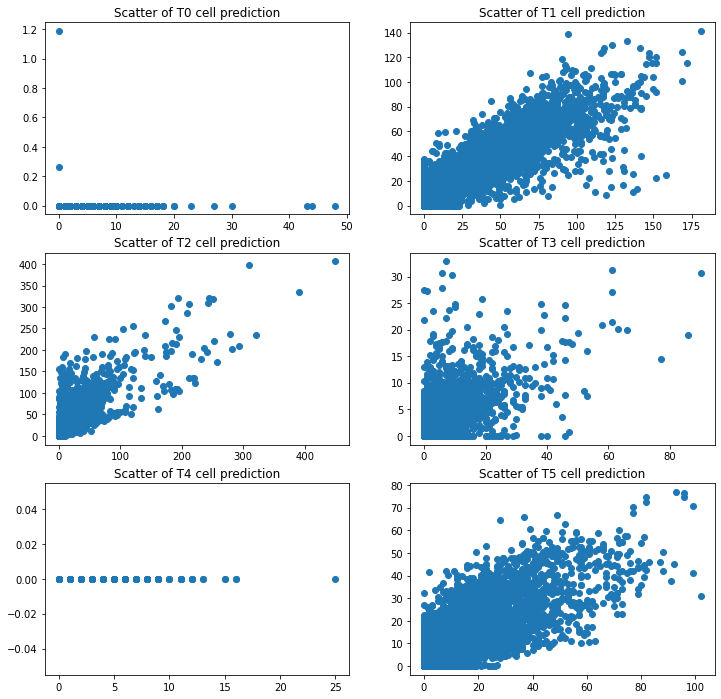

In [25]:
xtest = X[F!=1]
Ytest = Y.values[F!=1]
ypred = modelcv.predict(xtest)
fig, axes = plt.subplots(3,2, figsize=(12, 12), sharex=False, sharey=False)
ax = axes.ravel()
for i in range(6):
    ypre = ypred[:,i]
    ytest = Ytest[:,i]
    rmse = math.sqrt(mean_squared_error(ytest, ypre));
    scorr,_ = stats.spearmanr(ytest,ypre);
    r2 = r2_score(ytest,ypre);
    pcorr,_ = pearsonr(ypre,ytest);
    print('----------------------------------')
    print('T',i+1,' cell TestFold 1: ')
    print('RMSE',rmse)
    print('R2',r2)
    print('spearman correlation:',scorr)
    print('pearson correlation ',pcorr)
    ax[i].scatter(ytest,ypre)
    ax[i].set_title('Scatter of T{} cell prediction'.format(i))

#### Fold 2 for test

In [287]:
Xtrain,Xv, Ytrain,Yv = train_test_split(X[F!=2], Y.values[F!=2],test_size = 0.3)
# Fit
callback = keras.callbacks.EarlyStopping(monitor="val_loss",patience=10,restore_best_weights=True,mode='min')
model_history = modelcv.fit(Xtrain,Ytrain, 
                          epochs=30, 
                          batch_size=100, 
                          callbacks=[callback],
                          validation_data=(Xv, Yv))

Epoch 1/30
23/23 [==============================] - 67s 3s/step - loss: 115.9529 - r_square: 0.9016 - pearson_r: 0.8817 - val_loss: 549.4857 - val_r_square: 1.9988 - val_pearson_r: 0.6951
Epoch 2/30
23/23 [==============================] - 68s 3s/step - loss: 107.1244 - r_square: 0.8887 - pearson_r: 0.8970 - val_loss: 313.4417 - val_r_square: 1.4744 - val_pearson_r: 0.7456
Epoch 3/30
23/23 [==============================] - 66s 3s/step - loss: 94.2899 - r_square: 0.9177 - pearson_r: 0.9110 - val_loss: 867.0993 - val_r_square: 2.1688 - val_pearson_r: 0.5701
Epoch 4/30
23/23 [==============================] - 66s 3s/step - loss: 95.3253 - r_square: 0.9187 - pearson_r: 0.9093 - val_loss: 295.6663 - val_r_square: 1.4052 - val_pearson_r: 0.8008
Epoch 5/30
23/23 [==============================] - 68s 3s/step - loss: 100.1826 - r_square: 0.8939 - pearson_r: 0.9086 - val_loss: 307.3050 - val_r_square: 0.4422 - val_pearson_r: 0.7905
Epoch 6/30
23/23 [==============================] - 70s 3s/ste

----------------------------------
T 1  cell TestFold 2: 
RMSE 3.315246953752197
R2 -0.09734880385445699
spearman correlation: nan
pearson correlation  nan
----------------------------------
T 2  cell TestFold 2: 
RMSE 19.821390163011785
R2 0.6458798208541092
spearman correlation: 0.8461253255943807
pearson correlation  0.8283609247107457
----------------------------------
T 3  cell TestFold 2: 
RMSE 13.795952158834405
R2 0.824655866576245
spearman correlation: 0.8735152123851082
pearson correlation  0.9286489817375067
----------------------------------
T 4  cell TestFold 2: 
RMSE 6.213828660563038
R2 0.3190759421555065
spearman correlation: 0.707301167691516
pearson correlation  0.6532850296754342
----------------------------------
T 5  cell TestFold 2: 
RMSE 1.7635823569849656
R2 -0.1335655951383834
spearman correlation: nan
pearson correlation  nan
----------------------------------
T 6  cell TestFold 2: 
RMSE 13.795073601865713
R2 0.27647143620544523
spearman correlation: 0.4608413

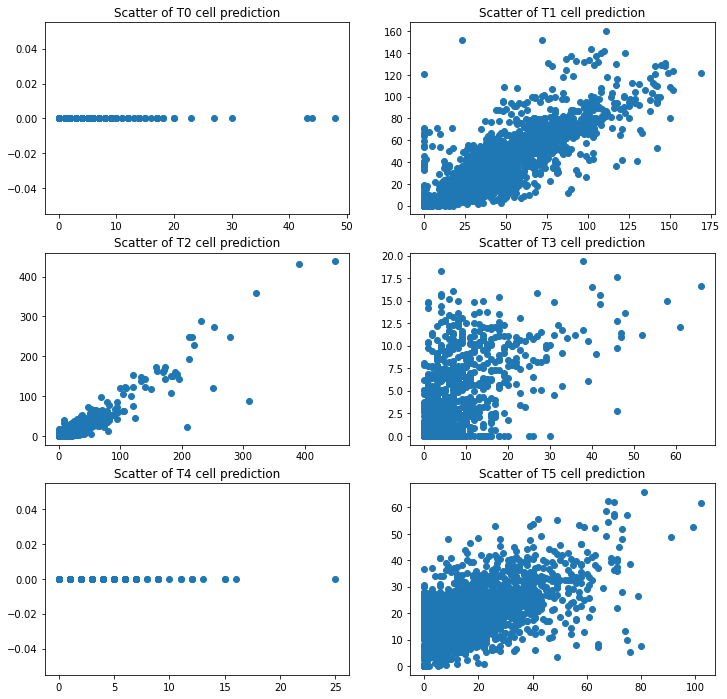

In [300]:
fig, axes = plt.subplots(3,2, figsize=(12, 12), sharex=False, sharey=False)
ax = axes.ravel()
for i in range(6):
    ypre = ypred[:,i]
    ytest = Ytest[:,i]
    rmse = sqrt(mean_squared_error(ytest, ypre));
    scorr,_ = stats.spearmanr(ytest,ypre);
    r2 = r2_score(ytest,ypre);
    pcorr,_ = pearsonr(ypre,ytest);
    print('----------------------------------')
    print('T',i+1,' cell TestFold 2: ')
    print('RMSE',rmse)
    print('R2',r2)
    print('spearman correlation:',scorr)
    print('pearson correlation ',pcorr)
    ax[i].scatter(ytest,ypre)
    ax[i].set_title('Scatter of T{} cell prediction'.format(i))

#### Fold 3 for test

In [274]:
Xtrain,Xv, Ytrain,Yv = train_test_split(X[F!=3], Y.values[F!=3],test_size = 0.3)
# Fit
callback = keras.callbacks.EarlyStopping(monitor="val_loss",patience=10,restore_best_weights=True,mode='min')
model_history = modelcv.fit(Xtrain,Ytrain, 
                          epochs=20, 
                          batch_size=100, 
                          callbacks=[callback],
                          validation_data=(Xv, Yv))

Epoch 1/20
24/24 [==============================] - 77s 3s/step - loss: 446.8045 - r_square: 0.5538 - pearson_r: 0.4172 - val_loss: 964.4548 - val_r_square: 1.9382 - val_pearson_r: -0.2891
Epoch 2/20
24/24 [==============================] - 70s 3s/step - loss: 301.2356 - r_square: 0.6499 - pearson_r: 0.6072 - val_loss: 606.4199 - val_r_square: 0.6629 - val_pearson_r: -0.2206
Epoch 3/20
24/24 [==============================] - 68s 3s/step - loss: 250.4981 - r_square: 0.7099 - pearson_r: 0.6958 - val_loss: 446.8565 - val_r_square: 0.3295 - val_pearson_r: 0.3860
Epoch 4/20
24/24 [==============================] - 68s 3s/step - loss: 212.1502 - r_square: 0.7641 - pearson_r: 0.7574 - val_loss: 555.6512 - val_r_square: 0.5171 - val_pearson_r: 0.1748
Epoch 5/20
24/24 [==============================] - 68s 3s/step - loss: 177.6117 - r_square: 0.8311 - pearson_r: 0.7989 - val_loss: 700.2510 - val_r_square: 1.4658 - val_pearson_r: 0.2994
Epoch 6/20
24/24 [==============================] - 68s 3s

----------------------------------
T 1  cell TestFold 3: 
RMSE 3.4394512813323614
R2 -0.08403020811860729
spearman correlation: -0.009452622981702742
pearson correlation  -0.0049919925471311475
----------------------------------
T 2  cell TestFold 3: 
RMSE 25.004133567525862
R2 0.5048341042476248
spearman correlation: 0.8947087306526341
pearson correlation  0.8919566179544756
----------------------------------
T 3  cell TestFold 3: 
RMSE 10.739320837128226
R2 0.8800692397657992
spearman correlation: 0.9117364509375455
pearson correlation  0.9580635718309929
----------------------------------
T 4  cell TestFold 3: 
RMSE 6.1616352798382685
R2 0.3895978786216906
spearman correlation: 0.751232144750253
pearson correlation  0.6358972029712229
----------------------------------
T 5  cell TestFold 3: 
RMSE 1.6212712927831807
R2 -0.15584088310905675
spearman correlation: nan
pearson correlation  nan
----------------------------------
T 6  cell TestFold 3: 
RMSE 14.94534200907705
R2 0.200018894

/Users/spike/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/spike/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


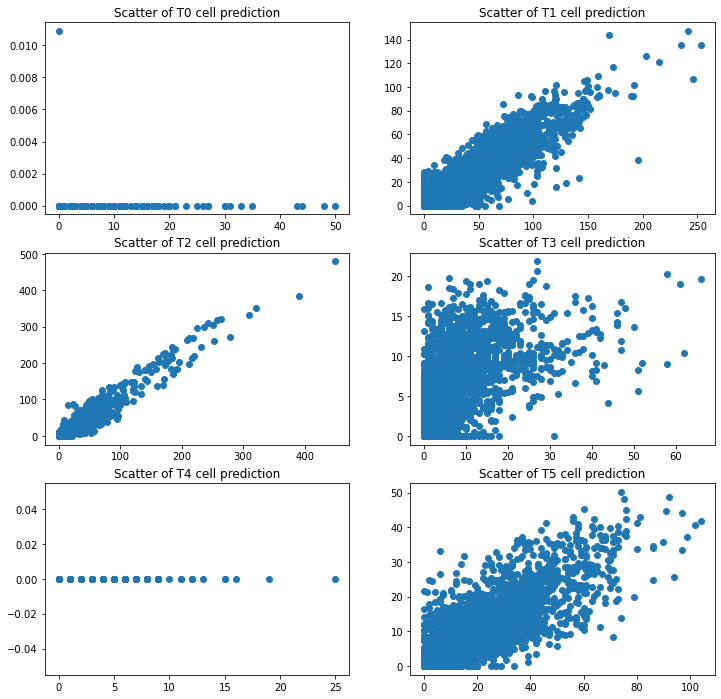

In [28]:
xtest = X[F!=3]
Ytest = Y.values[F!=3]
ypred = modelcv.predict(xtest)
fig, axes = plt.subplots(3,2, figsize=(12, 12), sharex=False, sharey=False)
ax = axes.ravel()
for i in range(6):
    ypre = ypred[:,i]
    ytest = Ytest[:,i]
    rmse = math.sqrt(mean_squared_error(ytest, ypre));
    scorr,_ = stats.spearmanr(ytest,ypre);
    r2 = r2_score(ytest,ypre);
    pcorr,_ = pearsonr(ypre,ytest);
    print('----------------------------------')
    print('T',i+1,' cell TestFold 3: ')
    print('RMSE',rmse)
    print('R2',r2)
    print('spearman correlation:',scorr)
    print('pearson correlation ',pcorr)
    ax[i].scatter(ytest,ypre)
    ax[i].set_title('Scatter of T{} cell prediction'.format(i))

report your results in terms of RMSE, Pearson Correlation Coefficient, Spearman Correlation Coefficient and R2 score for each cell type and each fold separately along with the average of each cell type across the 3 folds.

|cell type  |   RMSE     |    R square   |   spearman   |pearson|
|:----:|:----:|:----:|:----:|:----:|
|1   | 3.38 |   -0.091  | nan|nan|
|2   |  23.36   | 0.612   | 0.878|0.864|
|3   | 11.86    | 0.853    |  0.897 |0.948|
|4   | 6.19    | 0.381    |  0.682 |0.643|
|5   | 1.63    | -0.144    |  nan |nan|
|6   | 14.02   | 0.246   |  0.583 |0.713|